## Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import norm
from sklearn.tree import DecisionTreeClassifier, plot_tree

import xgboost as xgb

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input, AveragePooling1D, Dropout, Softmax, Layer
from keras.optimizers import Adam, Nadam
from keras.regularizers import L1, L2, Regularizer, L1L2
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, Callback, LambdaCallback
from keras.metrics import Metric
from keras import ops

from time import perf_counter
import functools
import itertools
import sys

In [2]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']

In [3]:
csv_path = r'..\combined.csv'
df = pd.read_csv(csv_path)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')
df[stresses] = df[stresses].astype(bool)

C:\Users\thead\AppData\Local\Temp\ipykernel_9104\1297277926.py:2: DtypeWarning: Columns (2155) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [4]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [5]:
trait_cols = np.array(['Photo',
       'Ci', 'Cond', 'CTleaf', 'Trmmol', 'WUEi', 'WUEin', 'Fv_Fm', 'Fv_Fo',
       'PI', 'SLA', 'LWC', 'Suc', 'OP', 'OP100', 'RWC', 'WP', 'N', 'C',
       'Neoxanthin', 'Violaxanthin', 'Lutein', 'Zeaxanthin', 'Chl_b', 'Chl_a',
       'B_carotene', 'Glucose', 'Fructose', 'Sucrose', 'Sugars', 'Starch',
       'Ellagic', 'Gal', 'Rut', 'CTs'])

## CNN

In [22]:
def drop_res(x, blur_factor=10):
    spec_x = x[:,:(x.shape[1]//blur_factor * blur_factor)]
    blur_x = (spec_x.flatten()
     .reshape((spec_x.shape[0] * spec_x.shape[1] // blur_factor, blur_factor))
     .mean(axis=1)
     .reshape((spec_x.shape[0], spec_x.shape[1] // blur_factor))
    )

    return blur_x

In [117]:
fuzzy_win = 1

In [30]:
def cnn_reshape(x):
    return x.reshape((-1, x.shape[1], 1))

In [61]:
blur_factor = 2

x_spec = df[spec_cols].values
yb = df[stresses].values.any(axis=1)

x_spec /= x_spec.max()

x_spec_train, x_spec_val, yb_train, yb_val = train_test_split(x_spec, yb, test_size=.2)

In [71]:
@functools.cache
def fuzzy_dx_init(shape, dtype=None):
    half_shape = list(shape)
    half_shape[0] //= 2
    half_shape = tuple(half_shape)
    return np.vstack((np.ones(half_shape) * -1/half_shape[0], np.ones(half_shape)/half_shape[0]))

dropout_k = .0
max_pool_k = 1

cnn_model = Sequential([
    Input(shape=(x_spec_train.shape[1],1)),
    Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    # Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    # Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    AveragePooling1D(blur_factor),
    Conv1D(20, 5, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(dropout_k),
    MaxPooling1D(max_pool_k),
    Conv1D(20, 5, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(dropout_k),
    MaxPooling1D(max_pool_k),
    Conv1D(20, 5, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(dropout_k),
    MaxPooling1D(max_pool_k),
    Conv1D(20, 5, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(dropout_k),
    MaxPooling1D(max_pool_k),
    Conv1D(20, 5, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(dropout_k),
    MaxPooling1D(max_pool_k),
    Conv1D(20, 5, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(dropout_k),
    MaxPooling1D(max_pool_k),
    Conv1D(20, 5, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(dropout_k),
    MaxPooling1D(max_pool_k),
    Conv1D(20, 5, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(dropout_k),
    MaxPooling1D(max_pool_k),
    Conv1D(20, 5, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(dropout_k),
    MaxPooling1D(max_pool_k),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(dropout_k),
    Dense(256, activation='relu'),
    Dropout(dropout_k),
    Dense(256, activation='relu'),
    Dropout(dropout_k),
    Dense(256, activation='relu'),
    Dropout(dropout_k),
    Dense(256, activation='relu'),
    Dropout(dropout_k),
    Dense(128, activation='relu'),
    Dropout(dropout_k),
    Dense(64, activation='relu'),
    Dropout(dropout_k),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Nadam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
start = perf_counter()

history = cnn_model.fit(
    cnn_reshape(x_spec_train[:20]),
    yb_train[:20],
    epochs=400,
    validation_data=(cnn_reshape(x_spec_val), yb_val),
    batch_size=200,
)

print(perf_counter() - start)

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2500 - loss: 0.6932 - val_accuracy: 0.6667 - val_loss: 0.6930
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7500 - loss: 0.6929 - val_accuracy: 0.6667 - val_loss: 0.6927
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7500 - loss: 0.6925 - val_accuracy: 0.6667 - val_loss: 0.6925
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7500 - loss: 0.6921 - val_accuracy: 0.6667 - val_loss: 0.6921
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7500 - loss: 0.6916 - val_accuracy: 0.6667 - val_loss: 0.6917
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7500 - loss: 0.6909 - val_accuracy: 0.6667 - val_loss: 0.6910
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7500 - loss: 0.6899 - val_accuracy: 0.6667 - val_loss: 0.6901
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7500 - loss: 0.6885 - val_accuracy: 0.6667 - val_

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['loss'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_loss']), np.ones(10)/10, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Loss')
ax.set_ylim((0, 1))
ax.set_title('CNN Loss over Training')

## NN

#### Preprocessing

In [6]:
x = df[trait_cols].values

x = (x - x.min(axis=0))/(x.max(axis=0)-x.min(axis=0))
y = df[stresses].values

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

In [8]:
yb_train, yb_val = y_train.any(axis=1), y_val.any(axis=1)

In [9]:
del df

##### Data Augmentation

In [10]:
z_aug = .6

aug_sample = np.random.randint(low=0, high=x_train.shape[0], size=(20000,))
x_train_aug = x_train[aug_sample]
y_train_aug = y_train[aug_sample]

x_train_aug += (
    np.random.random_sample(size=x_train_aug.shape) * z_aug*x_train.std(axis=0) - .5*z_aug*x_train.std(axis=0)
)

#### Tree

In [160]:
xgb_clf = xgb.XGBClassifier(
    early_stopping_rounds=5,
    max_depth=10,
    max_leaves=10,
    gamma=.05,
    scale_pos_weight=.75,
    learning_rate=1e-2,
    reg_alpha=0,
    reg_lambda=0,
)
xgb_clf.fit(x_train, yb_train, eval_set=[(x_val, yb_val)])

[0]	validation_0-logloss:0.62817
[1]	validation_0-logloss:0.62629
[2]	validation_0-logloss:0.62446
[3]	validation_0-logloss:0.62306
[4]	validation_0-logloss:0.62128
[5]	validation_0-logloss:0.61989
[6]	validation_0-logloss:0.61842
[7]	validation_0-logloss:0.61682
[8]	validation_0-logloss:0.61509
[9]	validation_0-logloss:0.61367
[10]	validation_0-logloss:0.61235
[11]	validation_0-logloss:0.61077
[12]	validation_0-logloss:0.60958
[13]	validation_0-logloss:0.60802
[14]	validation_0-logloss:0.60657
[15]	validation_0-logloss:0.60532
[16]	validation_0-logloss:0.60391
[17]	validation_0-logloss:0.60268
[18]	validation_0-logloss:0.60147
[19]	validation_0-logloss:0.60024
[20]	validation_0-logloss:0.59908
[21]	validation_0-logloss:0.59785
[22]	validation_0-logloss:0.59673
[23]	validation_0-logloss:0.59555
[24]	validation_0-logloss:0.59449
[25]	validation_0-logloss:0.59338
[26]	validation_0-logloss:0.59233
[27]	validation_0-logloss:0.59169
[28]	validation_0-logloss:0.59067
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.05, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [161]:
y_pred = xgb_clf.predict(x_val)
(y_pred == yb_val).mean(), (y_pred[yb_val] > .5).mean(), (y_pred[~yb_val] < .5).mean()

(0.8115942028985508, 0.9605263157894737, 0.4)

#### Custom Stuff

In [11]:
class Accuracy(Metric):
    def __init__(self, name='accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.accuracy = self.add_variable(
            shape=(),
            initializer='zeros',
            name='accuracy'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = tf.cast(tf.reduce_all((y_pred > .5) == y_true, axis=1), tf.float32)
        
        self.accuracy.assign(tf.reduce_mean(p))

    def result(self):
        return self.accuracy

CancelOut, based on [this paper](https://www.researchgate.net/publication/335698779_CancelOut_A_Layer_for_Feature_Selection_in_Deep_Neural_Networks)

In [12]:
class COReg(Regularizer):
    def __init__(self, lambda_1=1e-3, lambda_2=1e-3):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2

    def call(self, x):
        return -1*lambda_1*ops.var(x) + L1(lambda_2)(x)

class CancelOutLayer(Layer):
    def __init__(self, lambda_1=1e-3, lambda_2=1e-3, **kwargs):
        super(CancelOutLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        weight_shape = (1, input_shape[-1])

        
        
        self.kernel = self.add_weight(
            name='kernel', 
            shape=weight_shape,
            initializer='uniform',
            trainable=True,
            regularizer=COReg
        )
        
        self.bias = self.add_weight(
            name='bias', 
            shape=weight_shape,
            initializer='zeros',
            trainable=True
        )
        
        self.built=True
    
    #operation:
    def call(self, inputs):
        return (inputs * self.kernel) + self.bias
    
    #output shape
    def compute_output_shape(self, input_shape):
        return input_shape
    
    #for saving the model - only necessary if you have parameters in __init__
    def get_config(self):
        config = super(SingleConnected, self).get_config()
        return config

In [13]:
def drop_lr(epochs, lr):
    if epochs < 50:
        return 1e-2
    else:
        return 1e-3

#### Binary

In [14]:
dropout_k = 0
reg_k = 0
areg_k = 1e-4

model = Sequential([
    Input((x.shape[1],)),
    CancelOutLayer(lambda_1=1e-2, lambda_2=1e-3),
    Dense(128, kernel_regularizer=L1L2(reg_k), activity_regularizer=L2(areg_k), activation='relu'),
    Dropout(dropout_k),
    Dense(64, kernel_regularizer=L1L2(reg_k), activity_regularizer=L2(areg_k), activation='relu'),
    Dropout(dropout_k),
    Dense(64, kernel_regularizer=L1L2(reg_k), activity_regularizer=L2(areg_k), activation='relu'),
    Dropout(dropout_k),
    Dense(64, kernel_regularizer=L1L2(reg_k), activity_regularizer=L2(areg_k), activation='relu'),
    Dropout(dropout_k),
    Dense(256, kernel_regularizer=L1L2(reg_k), activity_regularizer=L2(areg_k), activation='relu'),
    Dropout(dropout_k),
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=Nadam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [15]:
start = perf_counter()

history = model.fit(
    x_train,
    yb_train,
    epochs=200,
    validation_data=(x_val, yb_val),
    batch_size=300,
    class_weight={0: 1, 1: 1}
    # callbacks=[LearningRateScheduler(drop_lr)]
)

print(perf_counter() - start)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.4719 - loss: 0.6936 - val_accuracy: 0.6763 - val_loss: 0.6927
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6580 - loss: 0.6928 - val_accuracy: 0.6763 - val_loss: 0.6920
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6563 - loss: 0.6922 - val_accuracy: 0.6763 - val_loss: 0.6913
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6675 - loss: 0.6914 - val_accuracy: 0.6763 - val_loss: 0.6905
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6671 - loss: 0.6906 - val_accuracy: 0.6763 - val_loss: 0.6896
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6575 - loss: 0.6900 - val_accuracy: 0.6763 - val_loss: 0.6887
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6671 - loss: 0.6888 - val_accuracy: 0.6763 - val_loss: 0.6876
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6571 - loss: 0.6882 - val_accuracy: 0.6763 - val_loss

Text(0.5, 1.0, 'Binary NN Loss over Training')

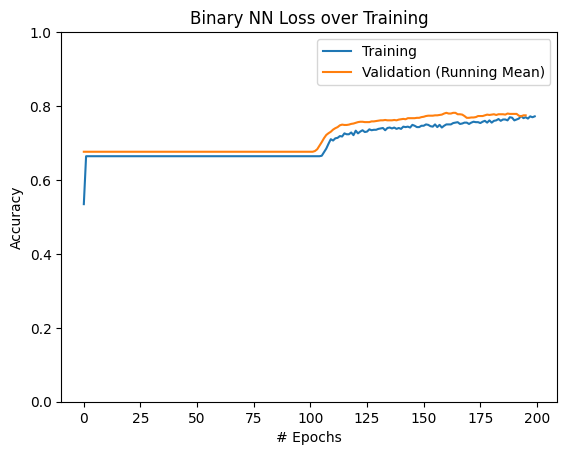

In [16]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['accuracy'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_accuracy']), np.ones(5)/5, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim((0, 1))
ax.set_title('Binary NN Loss over Training')

In [17]:
y_pred = model.predict(x_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [18]:
# True Positive Accuracy
(y_pred[yb_val] > .5).mean()

0.9714285714285714

In [19]:
# True Negative Accuracy
(y_pred[~yb_val] < .5).mean()

0.3582089552238806

#### Build

In [247]:
dropout_k = .05
reg_k = 1e-3

# model = Sequential([
#     Input((x.shape[1],)),
#     Dense(256, kernel_regularizer=L2(reg_k), activation='relu'),
#     Dropout(dropout_k),
#     Dense(256, kernel_regularizer=L2(reg_k), activation='relu'),
#     Dropout(dropout_k),
#     Dense(80, kernel_regularizer=L2(reg_k), activation='relu'),
#     Dropout(dropout_k),
#     Dense(40, kernel_regularizer=L2(reg_k), activation='relu'),
#     Dropout(dropout_k),
#     Dense(40, kernel_regularizer=L2(reg_k), activation='relu'),
#     Dropout(dropout_k),
#     Dense(20, kernel_regularizer=L2(reg_k), activation='relu'),
#     Dropout(dropout_k),
#     Dense(20, kernel_regularizer=L2(reg_k), activation='relu'),
#     Dropout(dropout_k),
#     Dense(y.shape[1], activation='sigmoid'),
# 

model = Sequential([
    Input((x.shape[1],)),
    CancelOutLayer(lambda_1=1e-3, lambda_2=1e-3),
    Dense(256, kernel_regularizer=L2(reg_k), activation='relu'),
    Dropout(dropout_k),
    Dense(256, kernel_regularizer=L2(reg_k), activation='relu'),
    Dropout(dropout_k),
    Dense(256, kernel_regularizer=L2(reg_k), activation='relu'),
    Dropout(dropout_k),
    Dense(256, kernel_regularizer=L2(reg_k), activation='relu'),
    Dropout(dropout_k),
    Dense(64, kernel_regularizer=L2(reg_k), activation='relu'),
    Dropout(dropout_k),
    Dense(y.shape[1], activation='softmax'),
])

model.compile(
    optimizer=Nadam(1e-2),
    loss='binary_crossentropy',
    metrics=[Accuracy],
)

#### Train

In [248]:
start = perf_counter()

history = model.fit(
    x_train,
    y_train,
    epochs=300,
    validation_data=(x_val, y_val),
    batch_size=1000,
    # callbacks=[LearningRateScheduler(drop_lr)]
)

print(perf_counter() - start)

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3424 - loss: 1.0798 - val_accuracy: 0.3575 - val_loss: 0.8408
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3424 - loss: 0.8400 - val_accuracy: 0.3575 - val_loss: 0.7037
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3424 - loss: 0.7031 - val_accuracy: 0.3575 - val_loss: 0.5989
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3424 - loss: 0.5985 - val_accuracy: 0.3575 - val_loss: 0.5119
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3424 - loss: 0.5115 - val_accuracy: 0.3575 - val_loss: 0.4378
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3424 - loss: 0.4374 - val_accuracy: 0.3575 - val_loss: 0.3748
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3424 - loss: 0.3745 - val_accuracy: 0.3575 - val_loss: 0.3219
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3424 - loss: 0.3215 - val_accuracy: 0.3575 - val_loss: 0

In [249]:
y_pred = model.predict(x_val)

(~y_val).mean(), ((y_pred > .5) == y_val).mean()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


(0.8202898550724638, 0.8202898550724638)

In [250]:
stresses, (~y_val).mean(axis=0), ((y_pred > .5) == y_val).mean(axis=0)

(['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity'],
 array([0.73913043, 0.91304348, 0.78743961, 0.83574879, 0.82608696]),
 array([0.73913043, 0.91304348, 0.78743961, 0.83574879, 0.82608696]))

Text(0.5, 1.0, 'NN Loss over Training')

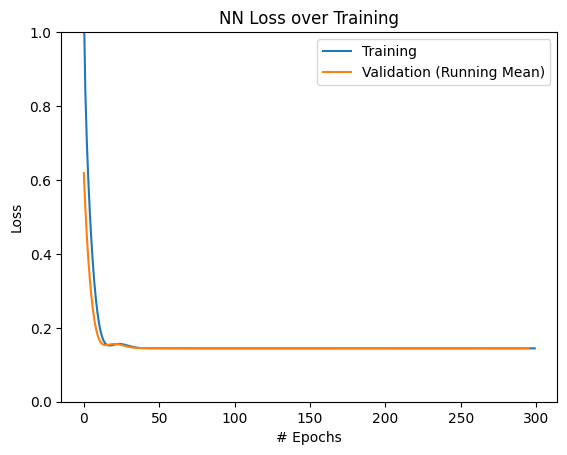

In [251]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['loss'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_loss']), np.ones(5)/5, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Loss')
ax.set_ylim((0, 1))
ax.set_title('NN Loss over Training')

## Interpretation

### Layer-Wise Relevance Propagation

In [298]:
n_samples = x.shape[0]

In [299]:
# i_s = np.random.choice(x_pca.shape[0], n_samples, replace=False)
# temp_x = x_pca[i_s]

temp_x = np.copy(x)
activations = [temp_x]
for layer in model.layers:
    temp_x = layer(temp_x)
    activations.append(temp_x.numpy())

In [300]:
try:
    x = x.numpy()
except:
    pass

In [301]:
alpha = 1
beta = 0
epsilon = 1e-5

prev_relevance = activations[-1]

for i in range(len(activations)-1,0,-1):
    start_time = perf_counter()
    
    weights = np.ones((activations[i-1].shape[1], activations[i].shape[1]))
    
    if model.layers[i-1].weights:
        weights = model.layers[i-1].weights[0].numpy()

    weights_p = weights * (weights > 0)
    weights_n = weights * (weights < 0)

    pre_activations_p = activations[i-1] @ weights_p
    pre_activations_n = activations[i-1] @ weights_n

    r = np.zeros(activations[i-1].shape)

    for j in range(activations[i-1].shape[1]):        
        r_a = activations[i-1][:,j,np.newaxis] * np.repeat(weights_p[j,np.newaxis],activations[i-1].shape[0],axis=0) / (pre_activations_p + epsilon)

        if beta == 0:
            r[:,j] = ((alpha * r_a) * prev_relevance).sum(axis=1)
            continue

        r_b = activations[i-1][:,j,np.newaxis] * np.repeat(weights_n[j,np.newaxis],activations[i-1].shape[0],axis=0) / (pre_activations_n + epsilon)
        r[:,j] = ((alpha * r_a - beta * r_b) * prev_relevance).sum(axis=1)

    prev_relevance = r

    print(f'{i}: {perf_counter() - start_time}s')

6: 0.006613000005017966s
5: 0.0016463000210933387s
4: 0.00138519995380193s
3: 0.0008210999658331275s
2: 0.004533899948000908s


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 35)

In [ ]:
del activations

In [ ]:
# input_relevances = prev_relevance / prev_relevance.max()
input_relevances = prev_relevance

#### Graphing

In [19]:
# n_stressed_samples = 6
# assert n_stressed_samples < n_samples

# i_stressed = np.random.choice(np.arange(i_s.shape[0])[y[i_s].any(axis=1)], n_stressed_samples, replace=False)
# i_s_stressed = i_s[i_stressed]

In [20]:
# fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(12,9))
# axs = list(itertools.chain.from_iterable(axs))
# x_h = np.arange(input_relevances.shape[1])

# ax_min, ax_max = input_relevances[i_stressed].min() * 1.05,input_relevances[i_stressed].max() * 1.05

# for i, ax in enumerate(axs):
#     ax.bar(x_h, input_relevances[i_stressed[i]])
#     ax.set_xticks(x_h, labels=trait_cols, rotation=90)
#     ax.set_title(
#         f'Sample #{i_s_stressed[i]} {[stresses[j] for j in range(len(stresses)) if y[i_s_stressed[i]][j]]}'
#     )
#     ax.set_ylabel('Normalized Relevance')
#     ax.set_ylim((ax_min, ax_max))

# fig.suptitle(f'Layer-wise Relevance Propagation ($\\alpha$={alpha}, $\\beta$={beta})')

#### Save to File

In [21]:
# lrp_df = pd.DataFrame(input_relevances, index=i_s, columns=trait_cols)
# lrp_df[stresses] = df.loc[i_s, stresses]
# lrp_df.to_csv(f'lrp_a{alpha}_b{beta}.csv')

## Trait Classification

### SIS
Simplified version of [this paper](https://proceedings.mlr.press/v89/carter19a/carter19a.pdf). 

Iteratively replaces different traits with their mean values. The trait that, when replaced, yields the highest accuracy is the least important. The least important trait is then replaced with its mean, and the process is repeated for the remaining traits, until the accuracy is below 80%. The remaining traits are thus the ones necessary for at least an 80% accuracy.  

In [22]:
important = {}

for stress_i, stress in enumerate(stresses):
    target = np.zeros((len(stresses),))
    target[stress_i] = 1
    
    selected = (y == target).all(axis=1)
    checked = np.zeros((x.shape[1],)).astype(bool)

    mask = np.repeat((1-np.identity(x.shape[1])).reshape((x.shape[1], 1, x.shape[1])), selected.sum(), axis=1)
    means = x.mean(axis=0).reshape((1, 1, x.shape[1])).repeat(x.shape[1], axis=0).repeat(selected.sum(), axis=1)
    
    remove_traits = []
    temp_x = np.copy(x[selected])
    
    for i in range(x.shape[1]):  
        masked = np.repeat(temp_x.reshape((1, selected.sum(), x.shape[1])), x.shape[1], axis=0)
        
        masked = (masked * mask) + (means * (1-mask))
        
        acc = np.zeros((x.shape[1],))
        
        for j in range(x.shape[1]):
            if checked[j]:
                continue
            acc[j] = ((model(masked[j]) > .5).numpy() == target).all(axis=1).mean()
        
        least_important = acc.argmax()
    
        temp_x = masked[least_important]
    
        remove_traits.append((least_important, acc[least_important]))
        checked[least_important] = True

    remove_traits = np.array(remove_traits)
    important[stress] = list(trait_cols[remove_traits[:,1]<.8])

    print(f'{stress}: {important[stress]}')

Gm: ['Photo', 'Ci', 'Cond', 'CTleaf', 'Trmmol', 'WUEi', 'WUEin', 'Fv_Fm', 'Fv_Fo', 'PI', 'SLA', 'LWC', 'Suc', 'OP', 'OP100', 'RWC', 'WP', 'N', 'C', 'Neoxanthin', 'Violaxanthin', 'Lutein', 'Zeaxanthin', 'Chl_b', 'Chl_a', 'B_carotene', 'Glucose', 'Fructose', 'Sucrose', 'Sugars', 'Starch', 'Ellagic', 'Gal', 'Rut', 'CTs']
Drought: ['Photo', 'Ci', 'Cond', 'CTleaf', 'Trmmol', 'WUEi', 'WUEin', 'Fv_Fm', 'Fv_Fo', 'PI', 'SLA', 'LWC', 'Suc', 'OP', 'OP100', 'RWC', 'WP', 'N', 'C', 'Neoxanthin', 'Violaxanthin', 'Lutein', 'Zeaxanthin', 'Chl_b', 'Chl_a', 'B_carotene', 'Glucose', 'Fructose', 'Sucrose', 'Sugars', 'Starch', 'Ellagic', 'Gal', 'Rut', 'CTs']
Nutrient_Deficiency: ['Photo', 'Ci', 'Cond', 'CTleaf', 'Trmmol', 'WUEi', 'WUEin', 'Fv_Fm', 'Fv_Fo', 'PI', 'SLA', 'LWC', 'Suc', 'OP', 'OP100', 'RWC', 'WP', 'N', 'C', 'Neoxanthin', 'Violaxanthin', 'Lutein', 'Zeaxanthin', 'Chl_b', 'Chl_a', 'B_carotene', 'Glucose', 'Fructose', 'Sucrose', 'Sugars', 'Starch', 'Ellagic', 'Gal', 'Rut', 'CTs']
Fs: ['Photo', 'Ci'

#### Noise

In [23]:
# noise_important = {}

# for stress_i, stress in enumerate(stresses):
#     target = np.zeros((len(stresses),))
#     target[stress_i] = 1
    
#     selected = (y == target).all(axis=1)
#     checked = np.zeros((x.shape[1],)).astype(bool)

#     mask = np.repeat((1-np.identity(x.shape[1])).reshape((x.shape[1], 1, x.shape[1])), selected.sum(), axis=1)
#     # noise = x.mean(axis=0).reshape((1, 1, x.shape[1])).repeat(x.shape[1], axis=0).repeat(selected.sum(), axis=1)
#     sigma = 2
#     noise = ((x[selected]) + sigma*x.std(axis=0)*(np.random.random_sample((selected.sum(), x.shape[1])) - 1/sigma)).reshape((1, selected.sum(), x.shape[1])).repeat(x.shape[1], axis=0)
    
#     remove_traits = []
#     temp_x = np.copy(x[selected])
    
#     for i in range(x.shape[1]):  
#         masked = np.repeat(temp_x.reshape((1, selected.sum(), x.shape[1])), x.shape[1], axis=0)
        
#         masked = (masked * mask) + (noise * (1-mask))
        
#         acc = np.zeros((x.shape[1],))
        
#         for j in range(x.shape[1]):
#             if checked[j]:
#                 continue
#             acc[j] = ((model(masked[j]) > .5).numpy() == target).all(axis=1).mean()
        
#         least_important = acc.argmax()
    
#         temp_x = masked[least_important]
    
#         remove_traits.append((least_important, acc[least_important]))
#         checked[least_important] = True

#     remove_traits = np.array(remove_traits)
#     noise_important[stress] = list(trait_cols[remove_traits[:,1]<.8])

#     print(f'{stress}: {noise_important[stress]}')

### Max

In [24]:
ir_normal = input_relevances / input_relevances.max()

In [25]:
means = np.empty((len(stresses), trait_cols.shape[0]))
for stress_i in range(len(stresses)):
    mask = np.zeros((y.shape[1],))
    mask[stress_i] = 1
    
    means[stress_i] = ir_normal[(y==mask).all(axis=1)].mean(axis=0)

In [26]:
thresh = .17

for stress_i in range(len(stresses)):
    i = (-1*means[stress_i, means[stress_i] > thresh]).argsort()
    print(f'{stresses[stress_i]}: {list(trait_cols[means[stress_i] > thresh][i])}')

print(f'Using threshold: {thresh}')

Gm: ['WP', 'Glucose', 'WUEin', 'B_carotene', 'Fv_Fm', 'Sucrose', 'Photo', 'Cond', 'Gal', 'RWC', 'OP', 'CTs', 'N', 'WUEi', 'LWC', 'Violaxanthin', 'Fv_Fo', 'Suc', 'Trmmol', 'Fructose', 'PI', 'OP100', 'Zeaxanthin', 'Sugars', 'Rut', 'Neoxanthin']
Drought: ['Violaxanthin', 'N', 'B_carotene', 'Gal', 'Fv_Fo', 'Fv_Fm', 'LWC', 'Glucose', 'PI', 'Fructose', 'WUEin', 'Sucrose', 'Neoxanthin', 'Suc', 'WP', 'RWC', 'Lutein', 'WUEi', 'Zeaxanthin', 'Chl_b', 'OP', 'SLA', 'Chl_a', 'CTs', 'Sugars', 'Photo', 'OP100', 'Rut']
Nutrient_Deficiency: ['Violaxanthin', 'OP', 'WUEin', 'WP', 'WUEi', 'Sucrose', 'Fv_Fo', 'RWC', 'LWC', 'Fv_Fm', 'Rut', 'Suc', 'Gal', 'Chl_b', 'N', 'CTs', 'B_carotene', 'Neoxanthin', 'Zeaxanthin', 'Ellagic', 'Photo', 'PI']
Fs: ['WUEin', 'N', 'WP', 'Sucrose', 'Fv_Fm', 'Gal', 'PI', 'Fv_Fo', 'Suc', 'LWC', 'WUEi', 'Glucose', 'RWC', 'B_carotene', 'OP', 'Violaxanthin', 'Photo', 'SLA', 'CTs', 'Sugars', 'Lutein', 'Chl_b', 'Zeaxanthin', 'Fructose', 'Neoxanthin', 'Rut', 'OP100']
Salinity: ['Sucrose',

Sorted

### Dominance

In [27]:
dists = np.empty((len(stresses), len(stresses)))

for s1 in range(len(stresses)):
    mask1 = np.zeros((len(stresses),))
    mask1[s1] = 1

    mean1 = x[(y==mask1).all(axis=1)].mean(axis=0)
    
    for s2 in range(len(stresses)):
        mask2 = np.zeros((len(stresses),))
        mask2[s2] = 1

        mean2 = x[(y==mask2).all(axis=1)].mean(axis=0)

        mask_both = np.logical_or(mask1, mask2)
        mean_both = x[(y==mask_both).all(axis=1)].mean(axis=0)

        d1 = np.linalg.norm(mean_both - mean1)
        d2 = np.linalg.norm(mean_both - mean2)

        if d1 + d2 == 0:
            dists[s1,s2] = 0
        else:
            dists[s1,s2] = (d2 - d1)/(d1 + d2)

        print(f'{stresses[s1]}: {(y==mask1).all(axis=1).sum()}, {stresses[s2]}: {(y==mask2).all(axis=1).sum()}, both: {(y==mask_both).all(axis=1).sum()}')

Gm: 156, Gm: 156, both: 156
Gm: 156, Drought: 34, both: 15
Gm: 156, Nutrient_Deficiency: 120, both: 0
Gm: 156, Fs: 70, both: 68
Gm: 156, Salinity: 89, both: 0
Drought: 34, Gm: 156, both: 15
Drought: 34, Drought: 34, both: 34
Drought: 34, Nutrient_Deficiency: 120, both: 20
Drought: 34, Fs: 70, both: 15
Drought: 34, Salinity: 89, both: 0
Nutrient_Deficiency: 120, Gm: 156, both: 0
Nutrient_Deficiency: 120, Drought: 34, both: 20
Nutrient_Deficiency: 120, Nutrient_Deficiency: 120, both: 120
Nutrient_Deficiency: 120, Fs: 70, both: 0
Nutrient_Deficiency: 120, Salinity: 89, both: 87
Fs: 70, Gm: 156, both: 68
Fs: 70, Drought: 34, both: 15
Fs: 70, Nutrient_Deficiency: 120, both: 0
Fs: 70, Fs: 70, both: 70
Fs: 70, Salinity: 89, both: 0
Salinity: 89, Gm: 156, both: 0
Salinity: 89, Drought: 34, both: 0
Salinity: 89, Nutrient_Deficiency: 120, both: 87
Salinity: 89, Fs: 70, both: 0
Salinity: 89, Salinity: 89, both: 89


C:\Users\thead\AppData\Local\Temp\ipykernel_21888\1216449937.py:16: RuntimeWarning: Mean of empty slice.
  mean_both = x[(y==mask_both).all(axis=1)].mean(axis=0)
C:\Users\thead\.virtualenvs\stress_prediction-gwCXE-ib\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


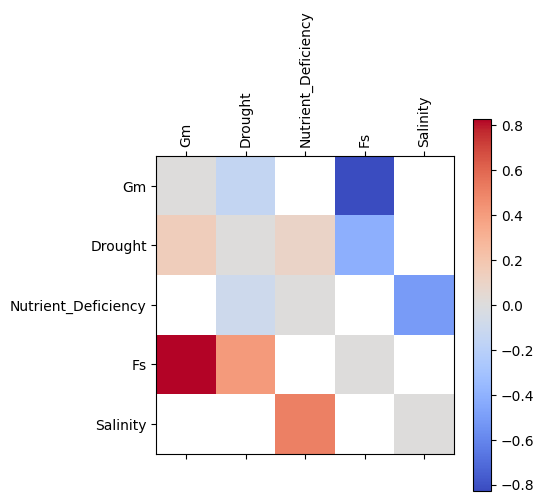

In [28]:
plt.matshow(dists, cmap='coolwarm')
plt.xticks(np.arange(len(stresses)), stresses, rotation=90)
plt.yticks(np.arange(len(stresses)), stresses)
plt.colorbar()

Positive value means closer to the variable on the vertical axis, or vertical axis variable is dominant over the horizontal axis variable.

### Point-Biserial Correlation

In [56]:
corrs = np.empty((len(stresses), len(trait_cols)))

for s_i in range(len(stresses)):
    mask = np.zeros((len(stresses),))
    mask[s_i] = 1
    mask_v = (y==mask).all(axis=1)

    mask_n = np.zeros((len(stresses),))
    mask_n_v = (y==mask_n).all(axis=1)

    c = (x[mask_v].mean(axis=0) - x[mask_n_v].mean(axis=0)) / x[mask_v | mask_n_v].std(axis=0)
    corrs[s_i] = c * np.sqrt(mask_v.sum() * mask_n_v.sum()) / (mask_v | mask_n_v).sum() 

In [57]:
norm.cdf(np.abs(corrs)).max()

0.6892757293534459